In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'boxcox', 'eta':'meanmax', 'phi':'linear_sincos', 'DL1r':'meanmax', 'm':'divmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.5916157281026244e-12


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = scale_variables.Shape_timesteps()
trainX_jets, trainX_other = timestep_builder.reshape_X(trainX, X_names, False)
testX_jets, testX_other = timestep_builder.reshape_X(testX, X_names, False)

# Save some memory 
del trainX
del testX 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(80000, 6, 6) (80000, 7) (80000, 12)
(20000, 6, 6) (20000, 7) (20000, 12)


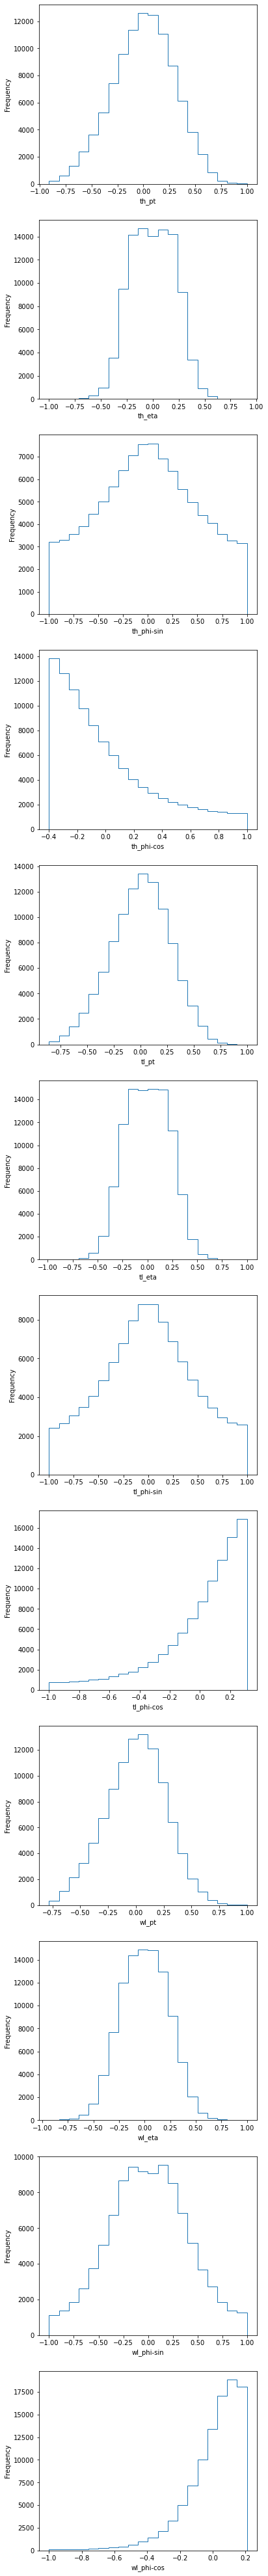

In [4]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*Y_total.shape[1]))
    for i in range(0, Y_total.shape[1]):
        plt.subplot(Y_total.shape[1], 1, i+1)
        plt.hist(Y_total[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables 
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Conv11 = Conv1D(filters=32, kernel_size=1, activation='relu', kernel_initializer=initializers.he_uniform())(jet_input)
    Conv12 = Conv1D(filters=32, kernel_size=1, activation='relu', kernel_initializer=initializers.he_uniform())(Conv11)
    flat_jets = Flatten()(Conv11)
    
    other_input = Input(shape=(trainX_other.shape[1]))
    Dense21 = Dense(32, activation='relu')(other_input)
    Dense22 = Dense(32, activation='relu')(Dense21)
    flat_other = Flatten()(Dense21)
    
    concat = concatenate([flat_other, flat_jets])
    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(128, activation='relu')(dense1)
    dense3 = Dense(64, activation='relu')(dense2)
    output = Dense(len(Y_names), activation='linear')(dense3)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=5e-6)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           256         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 6, 32)        224         input_1[0][0]                    
______________________________________________________________________________________________

In [7]:
# Fit model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Epochs= 2048

history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Train on 64000 samples, validate on 16000 samples
Epoch 1/2048
64000/64000 [==============================] - 3s 54us/sample - loss: 0.1467 - mse: 0.1467 - val_loss: 0.1339 - val_mse: 0.1339
Epoch 2/2048
64000/64000 [==============================] - 1s 11us/sample - loss: 0.1295 - mse: 0.1295 - val_loss: 0.1220 - val_mse: 0.1220
Epoch 3/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1205 - mse: 0.1205 - val_loss: 0.1155 - val_mse: 0.1155
Epoch 4/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1154 - mse: 0.1154 - val_loss: 0.1116 - val_mse: 0.1116
Epoch 5/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1121 - mse: 0.1121 - val_loss: 0.1088 - val_mse: 0.1088
Epoch 6/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1096 - mse: 0.1096 - val_loss: 0.1067 - val_mse: 0.1067
Epoch 7/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.1076 - mse: 0.1076 

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0659 - mse: 0.0659 - val_loss: 0.0652 - val_mse: 0.0652
Epoch 59/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0656 - mse: 0.0656 - val_loss: 0.0650 - val_mse: 0.0650
Epoch 60/2048
64000/64000 [==============================] - 1s 11us/sample - loss: 0.0654 - mse: 0.0654 - val_loss: 0.0648 - val_mse: 0.0648
Epoch 61/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0652 - mse: 0.0652 - val_loss: 0.0646 - val_mse: 0.0646
Epoch 62/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0650 - mse: 0.0650 - val_loss: 0.0645 - val_mse: 0.0645
Epoch 63/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0648 - mse: 0.0648 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 64/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0647 - mse: 0.0647 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 65/2048
64000/

Epoch 116/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0590 - mse: 0.0590 - val_loss: 0.0588 - val_mse: 0.0588
Epoch 117/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0587 - val_mse: 0.0587
Epoch 118/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 119/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0588 - mse: 0.0588 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 120/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0587 - mse: 0.0587 - val_loss: 0.0585 - val_mse: 0.0585
Epoch 121/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0587 - mse: 0.0587 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 122/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0586 - mse: 0.0586 - val_loss: 0.0584 - val_mse: 0.0584
Epoch

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0560 - val_mse: 0.0560
Epoch 174/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0559 - val_mse: 0.0559
Epoch 175/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0559 - mse: 0.0559 - val_loss: 0.0559 - val_mse: 0.0559
Epoch 176/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0559 - mse: 0.0559 - val_loss: 0.0559 - val_mse: 0.0559
Epoch 177/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0559 - mse: 0.0559 - val_loss: 0.0558 - val_mse: 0.0558
Epoch 178/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0558 - val_mse: 0.0558
Epoch 179/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0558 - val_mse: 0.0558
Epoch 180/2048
6400

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 231/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 232/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 233/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0541 - mse: 0.0541 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 234/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0540 - mse: 0.0540 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 235/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0540 - mse: 0.0540 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 236/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0540 - mse: 0.0540 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 237/2048
640

64000/64000 [==============================] - 1s 10us/sample - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0532 - val_mse: 0.0532
Epoch 288/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 289/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 290/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 291/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 292/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 293/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 294/2048
6

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 345/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 346/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 347/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 348/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0523 - val_mse: 0.0523
Epoch 349/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 350/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 351/2048
6400

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0509 - mse: 0.0509 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 402/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0509 - mse: 0.0509 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 403/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0509 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 404/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0509 - mse: 0.0509 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 405/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 406/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 407/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 408/2048
6400

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 459/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 460/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 461/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 462/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0510 - val_mse: 0.0510
Epoch 463/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0510 - val_mse: 0.0510
Epoch 464/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0510 - val_mse: 0.0510
Epoch 465/2048
64000/

Epoch 516/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 517/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 518/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 519/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 520/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 521/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 522/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0506 - val_mse: 0.0506
Epoc

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 574/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 575/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 576/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 577/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 578/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 579/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 580/2048
64000/

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 631/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 632/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 633/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 634/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 635/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0499 - val_mse: 0.0499
Epoch 636/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0498 - val_mse: 0.0498
Epoch 637/2048
64000/

Epoch 688/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 689/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 690/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 691/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 692/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 693/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 694/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0496 - val_mse: 0.0496
Epoch 

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 746/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 747/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 748/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 749/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 750/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 751/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0494 - val_mse: 0.0494
Epoch 752/2048
64000/

Epoch 803/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 804/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 805/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 806/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 807/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 808/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 809/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0492 - val_mse: 0.0492
Epoch 

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 861/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 862/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 863/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 864/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 865/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 866/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 867/2048
64000/

Epoch 918/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 919/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 920/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 921/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 922/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 923/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 924/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0488 - val_mse: 0.0488
Epoch

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 976/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 977/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 978/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 979/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 980/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 981/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 982/2048
64000/

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1033/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1034/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1035/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1036/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1037/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1038/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0486 - val_mse: 0.0486
Epoch 1039/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1090/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1091/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1092/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1093/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1094/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1095/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0458 - mse: 0.0458 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 1096/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1147/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1148/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1149/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1150/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1151/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1152/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0455 - mse: 0.0455 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1153/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1204/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1205/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1206/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1207/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1208/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1209/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0484 - val_mse: 0.0484
Epoch 1210/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1261/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1262/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1263/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1264/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1265/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1266/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 1267/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1318/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1319/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1320/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1321/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1322/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1323/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0449 - mse: 0.0449 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1324/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1375/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1376/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1377/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1378/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1379/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1380/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1381/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1432/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1433/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1434/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1435/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 1436/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1437/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1438/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1489/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1490/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1491/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1492/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1493/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1494/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1495/204

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1546/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1547/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1548/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1549/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1550/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1551/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1552/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1603/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1604/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1605/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1606/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1607/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1608/2048
64000/64000 [==============================] - 1s 8us/sample - loss: 0.0440 - mse: 0.0440 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 1609/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1660/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1661/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1662/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1663/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1664/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1665/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1666/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1717/2048
64000/64000 [==============================] - 1s 10us/sample - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1718/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1719/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1720/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1721/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1722/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1723/204

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1774/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1775/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1776/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1777/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1778/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1779/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1780/2048

64000/64000 [==============================] - 1s 9us/sample - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1831/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1832/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1833/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1834/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1835/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1836/2048
64000/64000 [==============================] - 1s 9us/sample - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 1837/2048

Text(0.5, 1.0, 'MSE loss')

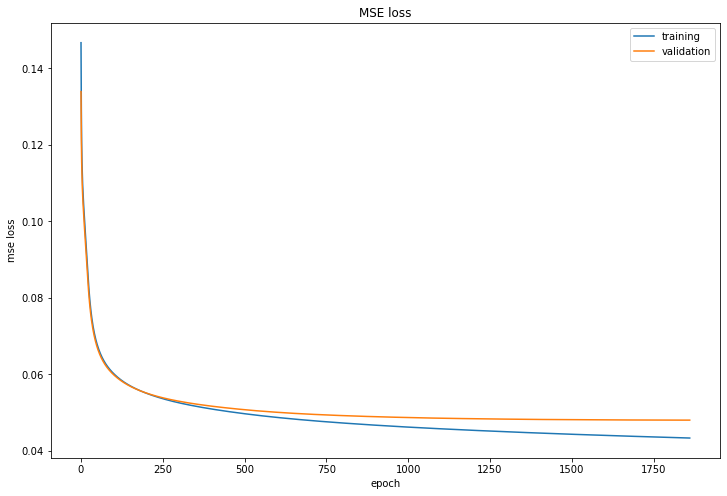

In [8]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [107]:
class Analysis:
    def __init__(self):
        self.crop = 100
        self.fsize = 6
        self.histogram_bins = 40
        
    def wrap_phi(self, var):
        var = var%(2*np.pi)
        var = var - 2*np.pi*(var > np.pi)
        return var
        
    def predictions_vs_sample(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize, self.fsize*len(names)))
        for i in range(0, len(names)):
            compare_small = compare[:self.crop,i]
            true_small = true[:self.crop,i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            plt.subplot(len(names), 1, i+1)
            plt.plot(range(0,self.crop), compare_small, 'bo', markersize=3, label = 'Predictions')
            plt.plot(range(0,self.crop), true_small, 'ro', markersize=3, label = 'True Value')
            ym, yM = plt.ylim()
            for x in range(self.crop):
                plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                            min(compare_small[x], true_small[x]), 
                            ymax= max(compare_small[x], true_small[x]))
            plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
            MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
            plt.xlabel('Sample')
            plt.xlim(0, self.crop)
            plt.ylabel(names[i])
            plt.title(names[i] + " MSE: " + str(MSE))
            plt.legend()
    
    def display_errors(self, compare, true, names, wrap_phi):
        MSE = 1/compare.size*np.sum((compare- true)**2)
        print("total MSE: " + str(MSE))
        print(" ")
        for i in range(len(names)):
            diff = compare[:,i] -true[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            MSE = 1/compare[:,i].size*np.sum((diff)**2)
            print("{0} MSE : ".format(names[i]), '%.10f'%MSE)
    
    def difference_histogram(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            diff = true[:,i] - compare[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            hist0, bin_edges = np.histogram(true[:, i], bins=self.histogram_bins)
            plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
            plt.xlabel("Difference (Mean: {0}, Std: {1})".format(np.mean(diff), np.std(diff)))
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
            
    def variable_histogram(self, compare, true, names, wrap_phi): 
        plt.figure(figsize=(self.fsize,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            compare_small = compare[:, i]
            true_small = true[:, i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            hist, edges = np.histogram(true_small, self.histogram_bins)
            plt.hist(true_small, edges, histtype='step', color='b', label='true values', density=True)
            plt.hist(compare_small, edges, histtype='step', color='r', label='predictions', density=True)
            plt.xlabel(names[i])
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
    
    def difference_vs_variable(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], true[:, i]-compare[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
            plt.xlabel('True ' + names[i])
            plt.legend()
            plt.ylabel('Difference')

In [108]:

display = Analysis()

predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

# Training scale plots 

In [109]:
display.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.047634388429377165
 
th_pt MSE :  0.0348486199
th_eta MSE :  0.0124452683
th_phi-sin MSE :  0.1611033933
th_phi-cos MSE :  0.0706567989
tl_pt MSE :  0.0261454472
tl_eta MSE :  0.0101466506
tl_phi-sin MSE :  0.1208278705
tl_phi-cos MSE :  0.0412236294
wl_pt MSE :  0.0159625659
wl_eta MSE :  0.0091672031
wl_phi-sin MSE :  0.0566385369
wl_phi-cos MSE :  0.0124466771


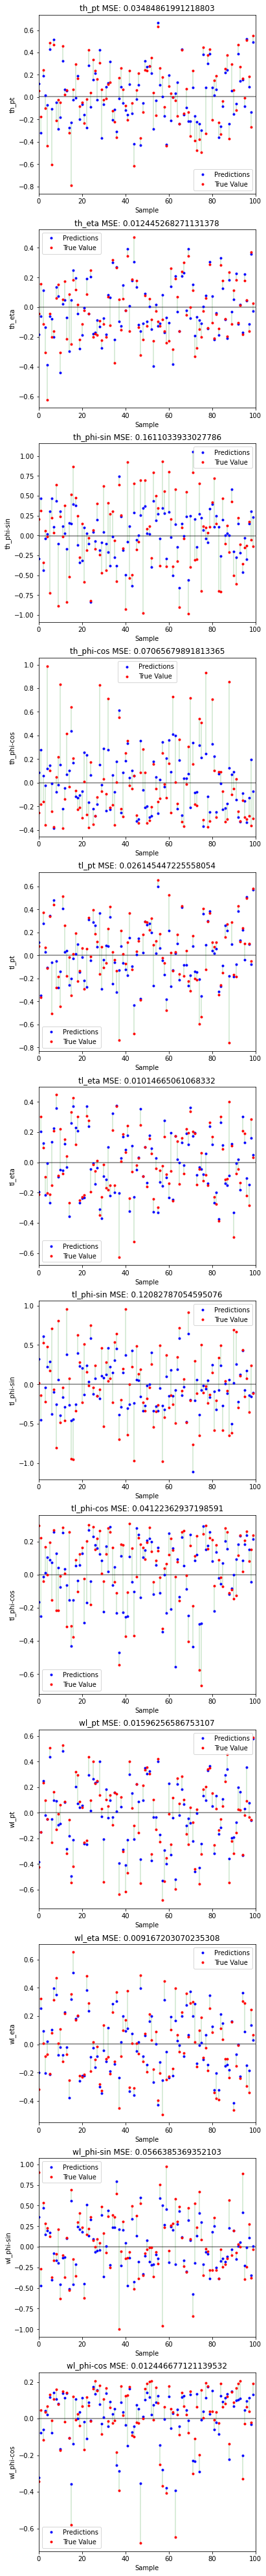

In [110]:
display.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

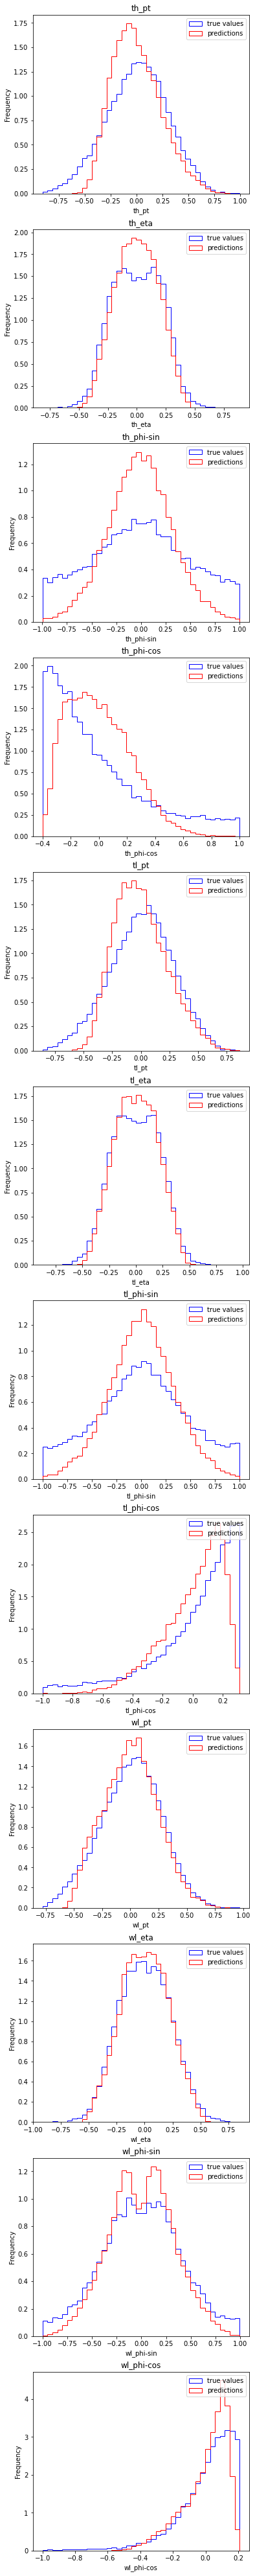

In [111]:
display.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False)

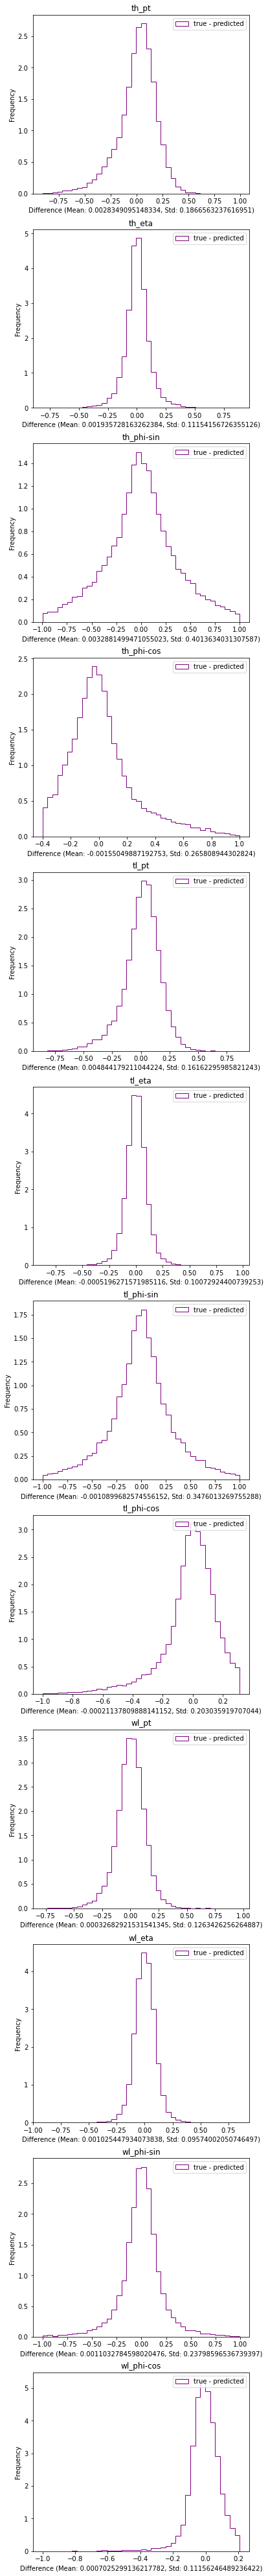

In [112]:
display.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False)

# Original scale plots

In [113]:
display.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 456.366962546421
 
th_pt MSE :  1883.7279469855
th_eta MSE :  0.6846125634
th_phi MSE :  0.8626753281
tl_pt MSE :  1543.3042743063
tl_eta MSE :  0.5077498763
tl_phi MSE :  0.5504650856
wl_pt MSE :  671.8467702576
wl_eta MSE :  0.3276075246
wl_phi MSE :  0.1999989317


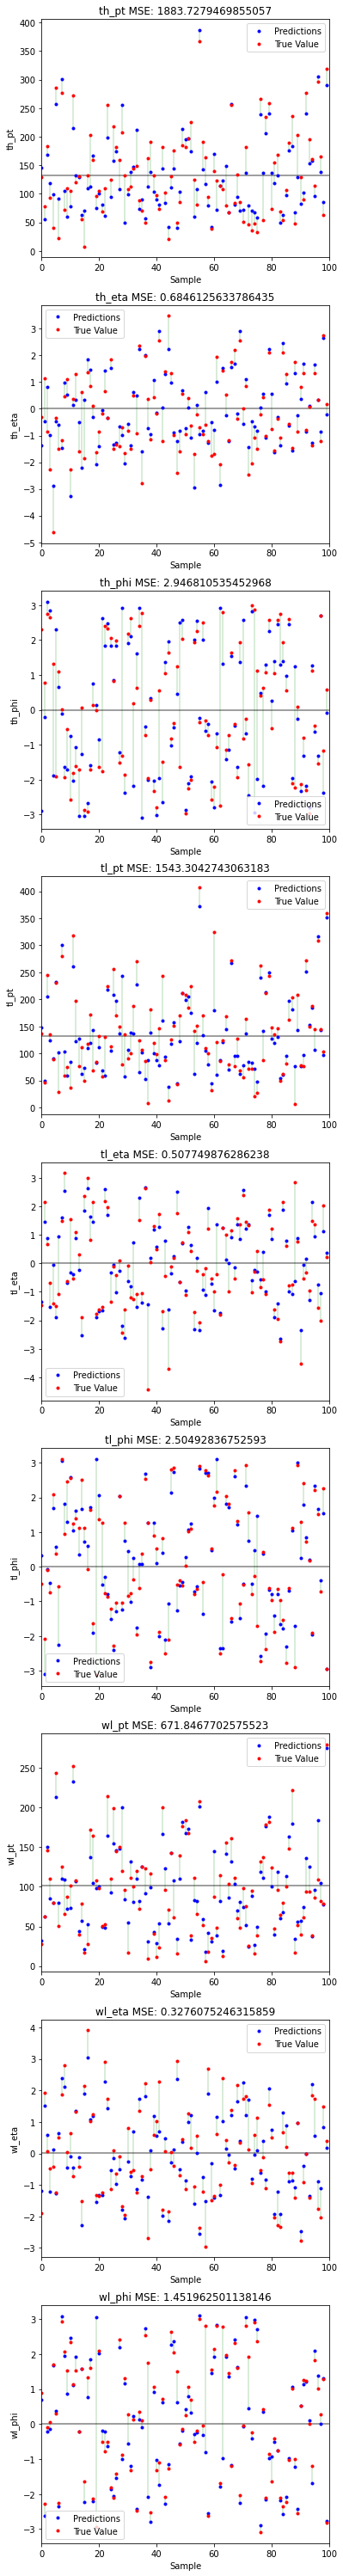

In [114]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

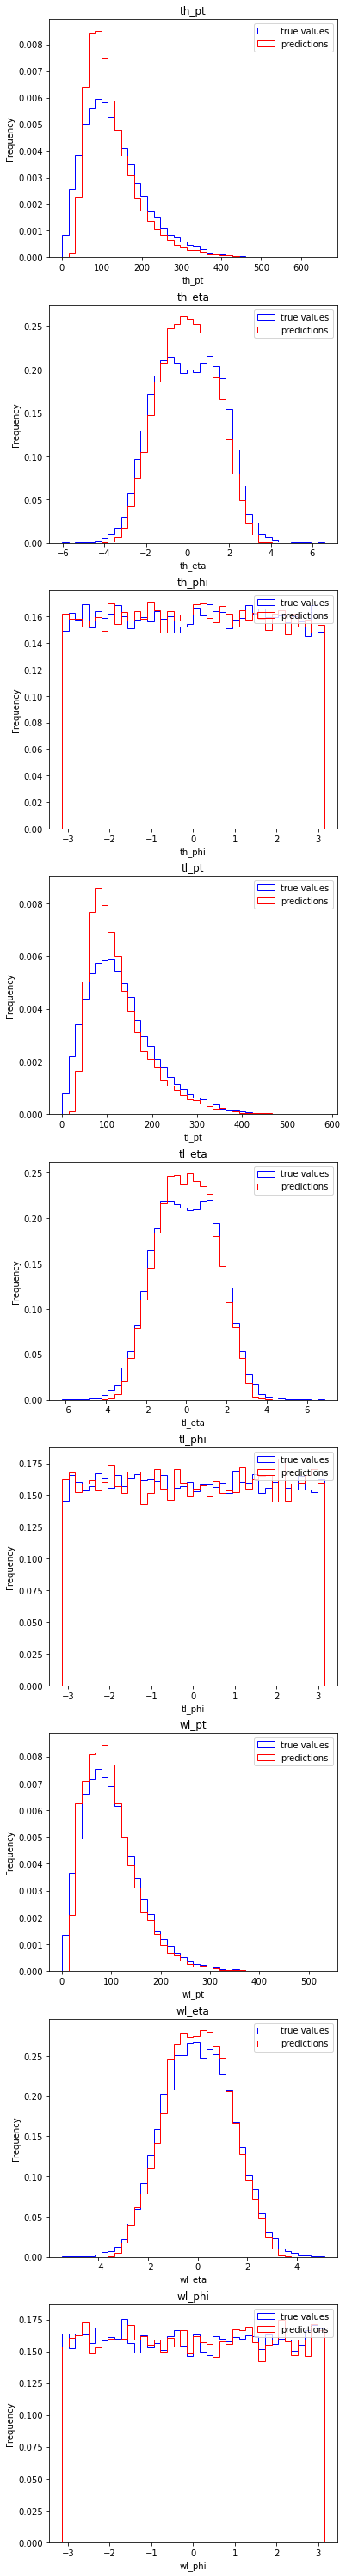

In [115]:
display.variable_histogram(predictions_origscale, true_origscale, Y_keys, True)

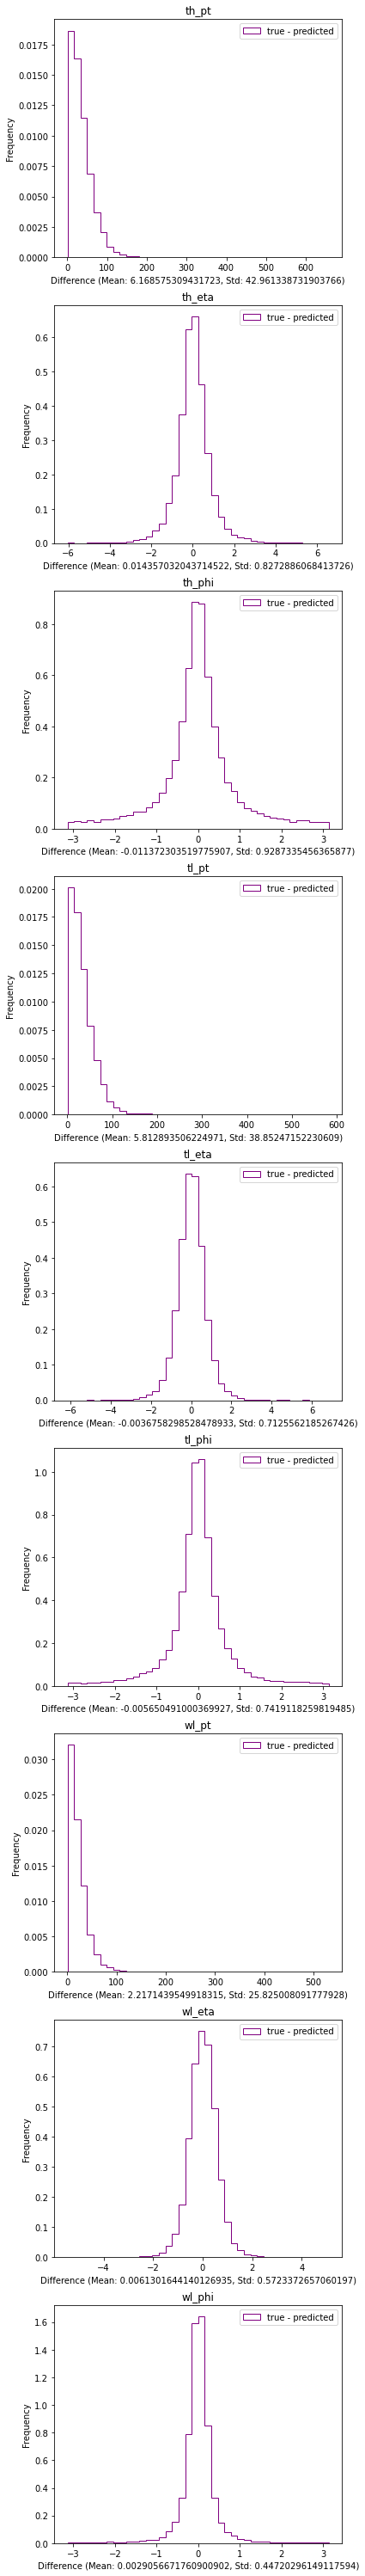

In [117]:
display.difference_histogram(predictions_origscale, true_origscale, Y_keys, True)

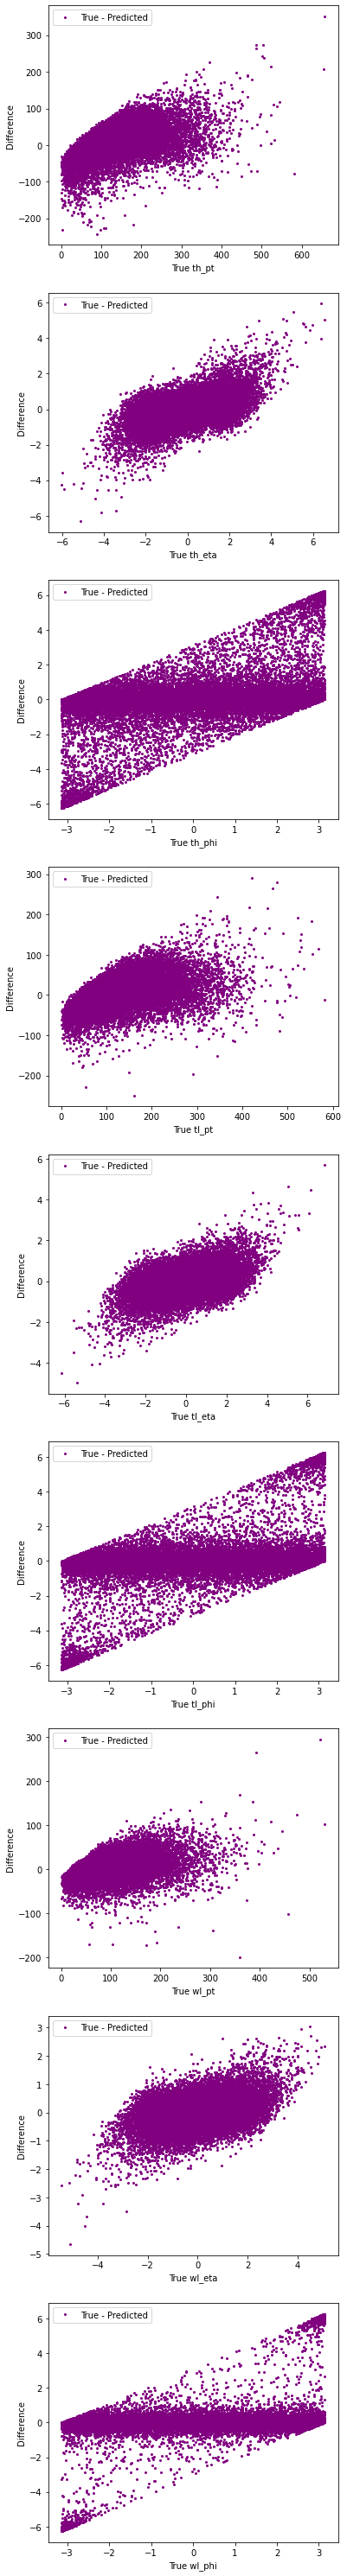

In [118]:
display.difference_vs_variable(predictions_origscale, true_origscale, Y_keys, True)